In [1]:
import torch
import torch.nn as nn
import numpy as np

from datasets.openml_datasets import OpenML_Dataset
from datasets.torch_datasets import Torch_Dataset
from utils.weakener import Weakener
from models.model import MLP
from utils.losses import PartialLoss,EMLoss
from utils.trainig_testing import train_and_evaluate,warm_up

In [2]:
Data = Torch_Dataset('mnist', batch_size=16)
Weak = Weakener(Data.num_classes)
#Weak.generate_M(model_class='pll')

In [3]:
print('Methods for Data Class','\n',[method for method in dir(Data) if (method[0] != '_') & callable(getattr(Data, method)) ],'\n'
      'Instances for Data Class','\n',[method for method in dir(Data) if (method[0] != '_') & (method not in [method for method in dir(Data) if (method[0] != '_') & callable(getattr(Data, method)) ]) ],'\n\n'
      'Methods for Weak Class','\n',[method for method in dir(Weak) if (method[0] != '_') & callable(getattr(Weak, method)) ],'\n'
      'Instances for Weak Class','\n',[method for method in dir(Weak) if (method[0] != '_') & (method not in [method for method in dir(Weak) if (method[0] != '_') & callable(getattr(Weak, method)) ]) ])

Methods for Data Class 
 ['get_data', 'get_dataloader', 'include_weak', 'transform'] 
Instances for Data Class 
 ['batch_size', 'dataset', 'num_classes', 'num_features', 'shuffle', 'test_dataset', 'test_num_samples', 'train_dataset', 'train_num_samples', 'weak_labels'] 

Methods for Weak Class 
 ['generate_M', 'generate_weak', 'generate_wl_priors', 'label_matrix', 'pll_weights', 'virtual_labels', 'virtual_matrix'] 
Instances for Weak Class 
 ['M', 'c', 'd', 'w', 'z']


In [4]:
Weak.generate_M('pll',pll_p=0.5)
Weak.M[:5,:],Weak.Z[:5,:]

(array([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.00217014, 0.00217014],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.00217014, 0.        , 0.00217014],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.00217014, 0.00217014, 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.00195312, 0.00195312, 0.00195312],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.00217014, 0.        , 0.        , 0.00217014]]),
 array([[0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 1]]))

In [5]:
train_X,train_y,test_X,test_y =  Data.get_data()
print(train_X.shape)

torch.Size([60000, 784])


In [6]:
Weak.generate_weak(train_y)

(tensor([908, 692, 809,  ..., 436, 543, 539], dtype=torch.int32),
 tensor([[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 0., 1.,  ..., 1., 1., 1.],
         [1., 1., 0.,  ..., 1., 0., 0.],
         ...,
         [0., 1., 1.,  ..., 1., 1., 0.],
         [1., 0., 0.,  ..., 0., 1., 0.],
         [1., 0., 0.,  ..., 1., 1., 0.]], dtype=torch.float64))

In [7]:
train_y[:5,:],Weak.z[:5],Weak.w[:5,:]

(tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]),
 tensor([908, 692, 809, 313, 860], dtype=torch.int32),
 tensor([[1., 1., 1., 0., 0., 1., 0., 1., 1., 1.],
         [1., 0., 1., 0., 1., 1., 1., 1., 1., 1.],
         [1., 1., 0., 0., 1., 1., 0., 1., 0., 0.],
         [0., 1., 0., 1., 0., 0., 0., 0., 1., 1.],
         [1., 1., 0., 1., 1., 0., 0., 1., 1., 1.]], dtype=torch.float64))

In [8]:
Data.include_weak(Weak.z)

In [9]:
trainloader,testloader = Data.get_dataloader()

In [10]:
print('Methods for MLP Class','\n',[method for method in dir(MLP) if (method[0] != '_') & callable(getattr(MLP, method)) ],'\n'
      'Instances for MLP Class','\n',[method for method in dir(MLP) if (method[0] != '_') & (method not in [method for method in dir(MLP) if (method[0] != '_') & callable(getattr(MLP, method))])])

Methods for MLP Class 
 ['add_module', 'apply', 'bfloat16', 'buffers', 'children', 'cpu', 'cuda', 'double', 'eval', 'extra_repr', 'float', 'forward', 'get_buffer', 'get_extra_state', 'get_parameter', 'get_submodule', 'half', 'ipu', 'load_state_dict', 'modules', 'named_buffers', 'named_children', 'named_modules', 'named_parameters', 'parameters', 'register_backward_hook', 'register_buffer', 'register_forward_hook', 'register_forward_pre_hook', 'register_full_backward_hook', 'register_load_state_dict_post_hook', 'register_module', 'register_parameter', 'requires_grad_', 'set_extra_state', 'share_memory', 'state_dict', 'to', 'to_empty', 'train', 'type', 'xpu', 'zero_grad'] 
Instances for MLP Class 
 ['T_destination', 'dump_patches']


In [11]:
mlp = MLP(Data.num_features,[Data.num_features],Data.num_classes, dropout_p=0.5, bn=True, activation =  'gelu')

In [12]:
mlp

MLP(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=784, bias=True)
    (1): Linear(in_features=784, out_features=10, bias=True)
  )
  (batch_norms): ModuleList(
    (0): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
)

In [13]:
optim = torch.optim.Adam(mlp.parameters(),lr=1e-2)
loss = EMLoss(Weak.M)

In [14]:
mlp, results = train_and_evaluate(mlp,trainloader,testloader,optimizer=optim,loss_fn=loss,num_epochs=10)


Epoch 1/10: Train Loss: 0.4109, Train Acc: 0.8311, Test Acc: 0.9281
Epoch 2/10: Train Loss: 0.3217, Train Acc: 0.8672, Test Acc: 0.9439
Epoch 3/10: Train Loss: 0.2955, Train Acc: 0.8834, Test Acc: 0.9516
Epoch 4/10: Train Loss: 0.2666, Train Acc: 0.8932, Test Acc: 0.9496
Epoch 5/10: Train Loss: 0.2577, Train Acc: 0.8988, Test Acc: 0.9554
Epoch 6/10: Train Loss: 0.2479, Train Acc: 0.9024, Test Acc: 0.9546
Epoch 7/10: Train Loss: 0.2362, Train Acc: 0.9074, Test Acc: 0.9576
Epoch 8/10: Train Loss: 0.2287, Train Acc: 0.9091, Test Acc: 0.9642
Epoch 9/10: Train Loss: 0.2241, Train Acc: 0.9110, Test Acc: 0.9608
Epoch 10/10: Train Loss: 0.2147, Train Acc: 0.9165, Test Acc: 0.9664


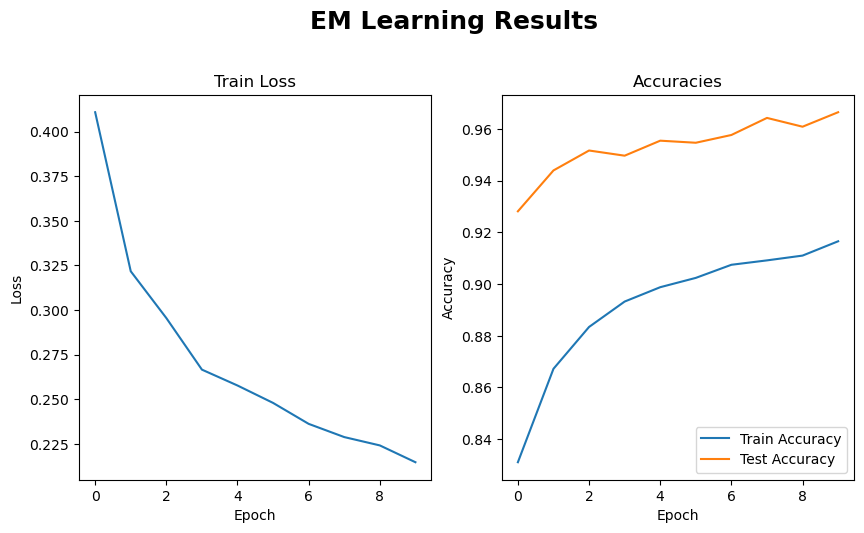

In [21]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first subplot (Train Loss)
ax1.plot(results['train_loss'])
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Train Loss')

# Plot the second subplot (Accuracies)
ax2.plot(results['train_acc'], label='Train Accuracy')
ax2.plot(results['test_acc'], label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracies')
ax2.legend()

fig.suptitle('EM Learning Results', fontsize=18, fontweight='bold', y=1.05)
# Show the plot
plt.show()